In [23]:
## conda activate xgboost-cpu

import numpy as np
import seaborn as sns
from pyprojroot.here import here
import re
import os, sys
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import anndata as ad
from tqdm.auto import tqdm

import marsilea as ma
import marsilea.plotter as mp

# Import functions
sys.path.insert(1, str(here('bin')))
from customPalette import shap_cell_types

In [2]:
%load_ext autoreload
%autoreload 2

#### Loading important genes per study

In [3]:
def generate_shap_data(
    shap_stats_path: str = '', 
    adata_path: str = '',
    gene_symbol_df_path: str='',
    stat: str = 'mean_abs',
    category_col: str = 'disease',
    expressed_gene_cellTypes_path: str = ''
):
    
    import numpy as np
    
    shap_stats = np.load(shap_stats_path)[stat]

    symbol_df = pd.read_pickle(gene_symbol_df_path)

    adata = ad.read_h5ad(adata_path, backed = 'r')

    adata.var = adata.var.merge(symbol_df, left_index=True, right_index=True, how='left')

    genes = adata.var['symbol'].values

    categories = adata.obs[category_col].cat.categories

    ## pandas dataframe

    shapDF = pd.DataFrame(shap_stats, index=genes, columns=categories)

    ## keeping only selected genes
    well_expressed_symbols = pd.read_csv(expressed_gene_cellTypes_path).query("CellType == 'pDC' and `% cells` > 5").symbol.values

    shapDF_fitl = shapDF.iloc[shapDF.index.isin(well_expressed_symbols),:]

    return shapDF_fitl



    

In [4]:
cell_type_i = shap_cell_types[0]


In [5]:
def generate_corr_matrix(cell_type = None):

    from pyprojroot import here 
    from scipy.stats import spearmanr, pearsonr
    
    studyID_stat_df = generate_shap_data(
        shap_stats_path = here(f'03_downstream_analysis/08_gene_importance/results/targetY_studyID/shap/shap_vals/total_studyID_{cell_type}_shap_stats.npz'), 
        adata_path = here(f'03_downstream_analysis/08_gene_importance/data/{cell_type}_adataMerged_SPECTRAgenes.log1p.h5ad'),
        gene_symbol_df_path = here('03_downstream_analysis/02_gene_universe_definition/results/04_selected_gene_list.pkl'),
        stat = 'mean_abs',
        category_col = 'studyID',
        expressed_gene_cellTypes_path = here('03_downstream_analysis/08_gene_importance/results/genes_expressing_cells.csv')
    )

    
    disease_stat_df = generate_shap_data(
        shap_stats_path = here(f'03_downstream_analysis/08_gene_importance/results/targetY_disease/shap/shap_vals/total_run1_{cell_type}_shap_stats.npz'), 
        adata_path = here(f'03_downstream_analysis/08_gene_importance/data/{cell_type}_adataMerged_SPECTRAgenes.log1p.h5ad'),
        gene_symbol_df_path = here('03_downstream_analysis/02_gene_universe_definition/results/04_selected_gene_list.pkl'),
        stat = 'mean_abs',
        category_col = 'disease',
        expressed_gene_cellTypes_path = here('03_downstream_analysis/08_gene_importance/results/genes_expressing_cells.csv')
    )

    
    disease_max_cor_dict = dict()
    
    correlation_matrix = []
    
    for target_dis in tqdm(disease_stat_df.columns, leave=False):
        corr_coef = []
        for target_studyID in studyID_stat_df.columns:
        
            v1 = studyID_stat_df[target_studyID].values
            v2 = disease_stat_df[target_dis].values
            
            corr_coef.append(pearsonr(v1, v2)[0])
    
        correlation_matrix.append(corr_coef)
    
    return np.array(correlation_matrix), disease_stat_df.columns, studyID_stat_df.columns

In [6]:
cell_type = 'Mono'

studyID_stat_df = generate_shap_data(
    shap_stats_path = here(f'03_downstream_analysis/08_gene_importance/results/targetY_studyID/shap/shap_vals/total_studyID_{cell_type}_shap_stats.npz'), 
    adata_path = here(f'03_downstream_analysis/08_gene_importance/data/{cell_type}_adataMerged_SPECTRAgenes.log1p.h5ad'),
    gene_symbol_df_path = here('03_downstream_analysis/02_gene_universe_definition/results/04_selected_gene_list.pkl'),
    stat = 'mean_abs',
    category_col = 'studyID',
    expressed_gene_cellTypes_path = here('03_downstream_analysis/08_gene_importance/results/genes_expressing_cells.csv')
)


disease_stat_df = generate_shap_data(
    shap_stats_path = here(f'03_downstream_analysis/08_gene_importance/results/targetY_disease/shap/shap_vals/total_run1_{cell_type}_shap_stats.npz'), 
    adata_path = here(f'03_downstream_analysis/08_gene_importance/data/{cell_type}_adataMerged_SPECTRAgenes.log1p.h5ad'),
    gene_symbol_df_path = here('03_downstream_analysis/02_gene_universe_definition/results/04_selected_gene_list.pkl'),
    stat = 'mean_abs',
    category_col = 'disease',
    expressed_gene_cellTypes_path = here('03_downstream_analysis/08_gene_importance/results/genes_expressing_cells.csv')
)


In [7]:
disease = 'PSA'

In [8]:
disease_stat_df['PSA']

NFYA        0.000013
LAP3        0.000002
CD99        0.000003
CD38        0.000005
CREBBP      0.000005
              ...   
C17orf49    0.000073
DYNLL2      0.000123
TXNIP       0.000001
CCL5        0.000002
PSMB3       0.000014
Name: PSA, Length: 522, dtype: float64

#### Loading adata

In [9]:
correlation_matrix = dict()
for ct in tqdm(shap_cell_types):
    correlation_matrix[ct], diseaseList, studyList = generate_corr_matrix(ct)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [11]:
adata = ad.read_h5ad(here(f'03_downstream_analysis/08_gene_importance/data/Mono_adataMerged_SPECTRAgenes.log1p.h5ad'))

In [12]:
diseaseXstudy = adata.obs[['studyID','disease']].drop_duplicates().groupby('disease', observed=True).count()
study_No_healthy = adata.obs[['disease','studyID']].groupby('studyID', observed=True).disease.unique().reset_index().apply(lambda x: 'healthy' not in x.disease, axis=1)

In [13]:
s = adata.obs[['disease','studyID']].groupby('studyID', observed=True).disease.unique().reset_index().disease.transform(lambda x: 'healthy' in x)
disease_with_healthy = np.unique(np.concatenate(adata.obs[['disease','studyID']].groupby('studyID', observed=True).disease.unique().reset_index()[s].disease.values))

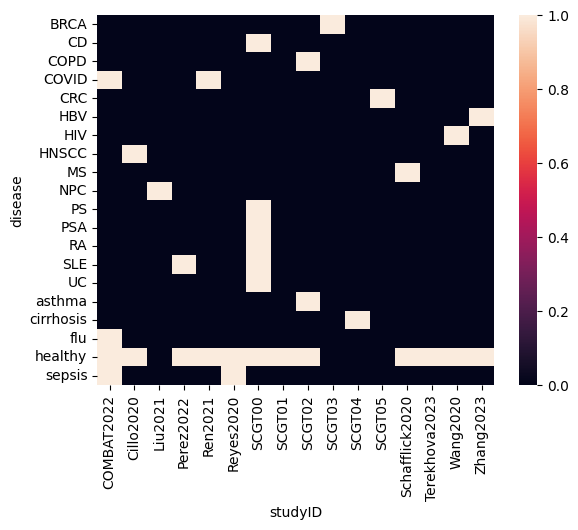

In [14]:
studyXdiseaseDF = adata.obs[['studyID','disease']].drop_duplicates()

SD_ct = pd.crosstab(studyXdiseaseDF['studyID'], studyXdiseaseDF['disease']).T

sns.heatmap(SD_ct > 0)

plt.show()


In [15]:
def getDiseaseGroup(d, CTmtx, ctrl = 'healthy'):

    if d == ctrl: return 3
    
    if CTmtx.loc[d].sum() == 1:
        return 0
    elif (CTmtx.loc[d].sum() == 2) and (CTmtx.loc[d,ctrl] == 1):
        return 1
    else:
        return 2
        
def getStudyGroup(s, CTmtx, ctrl = 'healthy'):

    study_i = CTmtx.loc[:,s]
    
    if study_i.sum() > 1:

        if (study_i.sum() == 2) and (study_i['healthy'] == 1):
            return 1
        else:
            return 2

    else:
        return 0

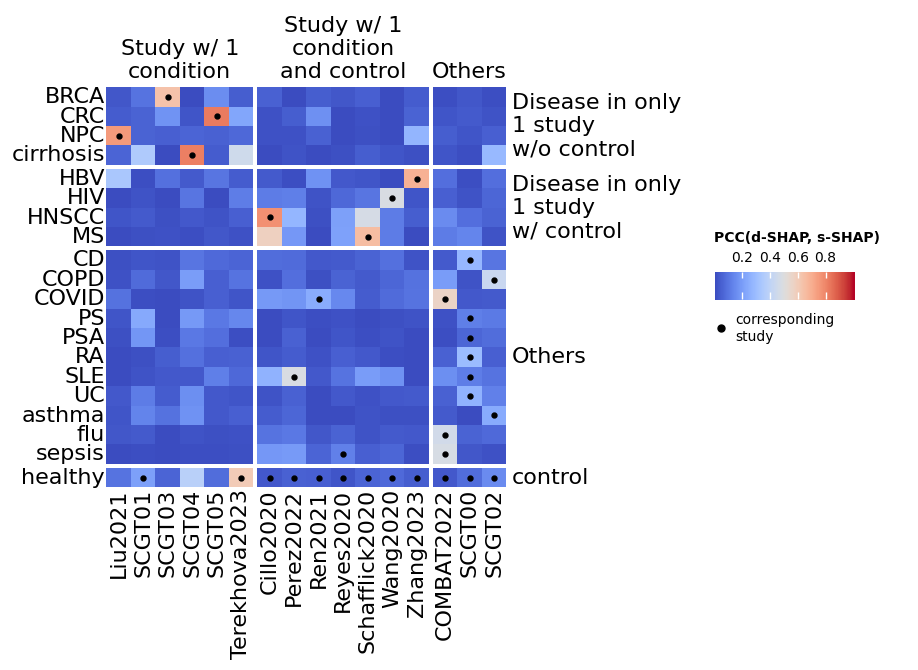

In [30]:
mpl.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.size'] = '16'

h = ma.Heatmap(np.stack(list(correlation_matrix.values())).mean(axis=0), 
               vmin=0, vmax=1, 
               cbar_kws = {'orientation':'horizontal'},
               label = 'PCC(d-SHAP, s-SHAP)')

h.add_layer(mp.MarkerMesh(SD_ct > 0, size = 50, marker = '.', label = 'corresponding\nstudy'))

h.add_right(mp.Chunk(['Disease in only\n1 study\nw/o control','Disease in only\n1 study\nw/ control','Others','control'], rotation = 0))
h.add_top(mp.Chunk(['Study w/ 1\ncondition','Study w/ 1\ncondition\nand control','Others']))

h.group_rows([getDiseaseGroup(d, SD_ct.dot(SD_ct.T))  for d in diseaseList])
h.group_cols([getStudyGroup(s,SD_ct)  for s in studyList])

h.add_bottom(mp.Labels(studyList))
h.add_left(mp.Labels(diseaseList))

h.add_legends()

h.save(here('03_downstream_analysis/08_gene_importance/figures/dshap_sshap_corr.svg'))

In [211]:
np.where(np.argsort(-studyID_stat_df, axis=0) == 26)

(array([  1,   2,   3,   4,   5,   8,  13,  14,  21,  35,  51, 106, 134,
        182, 332, 348]),
 array([11,  7,  8, 10,  3,  9,  1,  0, 15,  6,  5,  2, 13, 14,  4, 12]))

In [214]:
studyID_stat_df.iloc[26]

0.0047502913857504665

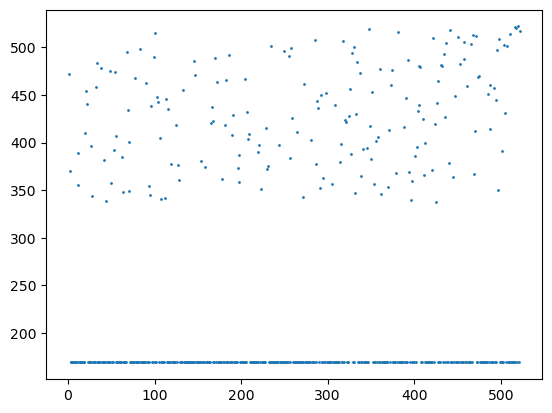

In [41]:
plt.scatter(x = disease_stat_df['sepsis'].rank(ascending=True), y=studyID_stat_df['COMBAT2022'].rank(ascending=True), s=1)

In [38]:
studyID_stat_df['COMBAT2022'].sort_values().rank()

NFYA       169.0
LY96       169.0
MCOLN2     169.0
NR4A2      169.0
BANK1      169.0
           ...  
NDUFA13    518.0
WDR83OS    519.0
EEF1G      520.0
RNASEK     521.0
UBE2V1     522.0
Name: COMBAT2022, Length: 522, dtype: float64

In [39]:
studyID_stat_df['COMBAT2022'].sort_values()

NFYA       0.000000
LY96       0.000000
MCOLN2     0.000000
NR4A2      0.000000
BANK1      0.000000
             ...   
NDUFA13    0.229917
WDR83OS    0.394508
EEF1G      0.827030
RNASEK     1.140293
UBE2V1     1.884217
Name: COMBAT2022, Length: 522, dtype: float64